In [1]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelBinarizer

In [ ]:
import torch_directml
dml = torch_directml.device()
print("device", dml)

In [2]:
base_dir = "../data/archive/"
csv_path = "../data/archive/hasy-data-labels.csv"

In [3]:
df = pd.read_csv(csv_path)
labels = df['symbol_id']

label_binarizer = LabelBinarizer()
label_binarizer.fit(labels)

num_of_classes = label_binarizer.classes_.shape[0]
print("number of classes:", num_of_classes)

number of classes: 369


In [4]:
class LatexSymbolDataset(Dataset):
    def __init__(self, base_dir: str, csv_path: str, label_binarizer: LabelBinarizer) -> None:
        self.base_dir = base_dir
        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        label = self.df.loc[index, "symbol_id"]
        path = self.df.loc[index, "path"]

        img_path = os.path.join(self.base_dir, path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_tensor = torch.FloatTensor(img)[None, :, :]

        label_encoded = label_binarizer.transform([label])[0]
        label_tensor = torch.FloatTensor(label_encoded)
        
        return img_tensor, label_tensor

In [5]:
training_dataset = LatexSymbolDataset(base_dir, csv_path, label_binarizer)
test_dataset = LatexSymbolDataset(base_dir, csv_path, label_binarizer)

training_dataloader = DataLoader(training_dataset, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=True)

In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_of_classes) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=64 * 5 * 5, out_features=1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(1024, num_of_classes)
        )

        # 1 * 32 * 32
        # 32 * 28 * 28
        # 32 * 14 * 14
        # 64 * 10 * 10
        # 64 * 5 * 5

        self.init_weights()

    def forward(self, x):
        return self.model(x)
    
    def init_weights(self):
        for module in self.model:
            if isinstance(module, nn.Conv2d):
                nn.init.xavier_uniform_(module.weight)

                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

In [10]:
def get_accuracy(y_pred, y_train):
    y_pred_index = torch.argmax(y_pred, 1)
    y_train_index = torch.argmax(y_train, 1)

    num_correct = (y_pred_index == y_train_index).sum().item()
    num_samples = y_pred.shape[0]

    return num_correct / num_samples

In [11]:
model = CNN(1, num_of_classes)

num_epochs = 40
learning_rate = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [12]:
# model.to(dml)

# collect stats
train_loss = []
train_acc = []
test_acc = []

for epoch in range(num_epochs):
    
    model.train()

    for index, (X_train, y_train) in enumerate(training_dataloader):
        # move to GPU
        # X_train.to(dml)
        # y_train.to(dml)

        # forward
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        acc = get_accuracy(y_pred, y_train)

        # collect stats
        train_loss.append(loss.item())
        train_acc.append(acc)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"EPOCH {epoch} | BATCH {index} of {len(training_dataloader)} | LOSS {loss.item():.4f} | ACCURACY {acc:.4f}")

    model.eval()
    torch.no_grad()

    for index, (X_test, y_test) in enumerate(test_dataloader):

        # move to GPU
        # X_test.to(dml)
        # y_test.to(dml)

        # forward
        y_pred = model(X_test)
        acc = get_accuracy(y_pred, y_test)

        # collect stats
        test_acc.append(acc)

EPOCH 0 | BATCH 0 of 169 | LOSS 129.4643 | ACCURACY 0.0030
EPOCH 0 | BATCH 1 of 169 | LOSS 38.3132 | ACCURACY 0.0030
EPOCH 0 | BATCH 2 of 169 | LOSS 15.6449 | ACCURACY 0.0070
EPOCH 0 | BATCH 3 of 169 | LOSS 7.7813 | ACCURACY 0.0120
EPOCH 0 | BATCH 4 of 169 | LOSS 6.0833 | ACCURACY 0.0080
EPOCH 0 | BATCH 5 of 169 | LOSS 5.8253 | ACCURACY 0.0050
EPOCH 0 | BATCH 6 of 169 | LOSS 5.8008 | ACCURACY 0.0130
EPOCH 0 | BATCH 7 of 169 | LOSS 5.7856 | ACCURACY 0.0140
EPOCH 0 | BATCH 8 of 169 | LOSS 5.7580 | ACCURACY 0.0080
EPOCH 0 | BATCH 9 of 169 | LOSS 5.7425 | ACCURACY 0.0180
EPOCH 0 | BATCH 10 of 169 | LOSS 5.7467 | ACCURACY 0.0130
EPOCH 0 | BATCH 11 of 169 | LOSS 5.6819 | ACCURACY 0.0100
EPOCH 0 | BATCH 12 of 169 | LOSS 5.7113 | ACCURACY 0.0130
EPOCH 0 | BATCH 13 of 169 | LOSS 5.7081 | ACCURACY 0.0130
EPOCH 0 | BATCH 14 of 169 | LOSS 5.6227 | ACCURACY 0.0170
EPOCH 0 | BATCH 15 of 169 | LOSS 5.6465 | ACCURACY 0.0200
EPOCH 0 | BATCH 16 of 169 | LOSS 5.6630 | ACCURACY 0.0180
EPOCH 0 | BATCH 17 o

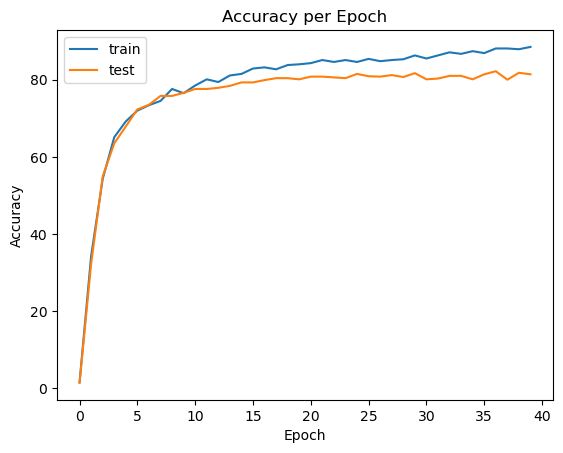

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(num_epochs), train_acc, label="train")
ax.plot(range(num_epochs), test_acc, label="test")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy per Epoch')
ax.legend()
plt.show()

In [15]:
out = model(X_test[76][None, :, :, :])
_, predicted = torch.max(out, 1)
print(predicted)
print(y_test_int[76])

tensor([102], device='privateuseone:0')
tensor(309., device='privateuseone:0')


In [18]:
from torch import save

model = model.to("cpu")
with open('model_state.pt', 'wb') as f: 
        save(model.state_dict(), f)

In [17]:
from torch import load

with open('model_state.pt', 'rb') as f: 
        model.load_state_dict(load(f))  